In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import tensorflow

EXTRACTION OF PRETRAINED NETWORK FROM KERAS


In [ ]:
img_height, img_width = (224,224)
batch_size = 32
IMG_SHAPE = (img_height, img_width, 3)
train_data_dir = r"G:/TARP/train"
valid_data_dir = r"G:/TARP/val"
test_data_dir = r"G:/TARP/test"
#test_data_dir = r"/content/drive/MyDrive/outputfolder/test"
#image.open()

In [ ]:

train_datagen = ImageDataGenerator(
                                     shear_range=0.2,zoom_range=0.2,
                                 horizontal_flip=True,
                                   validation_split=0.4)
                                   # rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                      class_mode='categorical')
                       
                                       #   subset='training')# set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as validation data  
                                                                                                       

Found 2448 images belonging to 3 classes.
Found 309 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Aug_overvol': 0, 'aug_normal': 1, 'non_overload_vehicles': 2}

In [ ]:
y_train = train_generator.classes
len(y_train)

2448

In [ ]:
nb_validation_samples = 309

In [ ]:
dir(train_generator)
#type(train_generator.labels)
print(train_generator.classes)
#y_train = train_generator.classes
y_train = train_generator.classes
y_train.shape

[0 0 0 ... 2 2 2]


(2448,)

In [ ]:
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                   
                                                   batch_size = 1, 
                                                    class_mode='categorical')
                                                    #subset='validation') #set as testing data

Found 307 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape
#print(type(x))
#x

(1, 224, 224, 3)

RESNET50
ARCHITECTURE

In [ ]:
def create_model():

  base_model_3 = MobileNetV2(include_top = False, weights='imagenet',input_shape = IMG_SHAPE)
 
 #the top layer is false coz we want to classify our own classes
#we use weights from imagenet(pre-trained weights) to classify our model
  x = base_model_3.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  predictions = Dense(train_generator.num_classes, activation='softmax')(x)
  model = Model(inputs=base_model_3.input, outputs=predictions)

  for layer in base_model_3.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 0.01
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

#plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# 100 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#checkpointing
#checkpoint_path = "/content/drive/MyDrive/cp-0021.ckpt.data-00000-of-00001"
#checkpoint_path = "C:/Users/DHANVANTH/SAMSUNG/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_path = "G:/TARP/Resnet/cp-0021.ckpt.data-00000-of-00001"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor = 'val_accuracy',
   filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    #save_freq=5*batch_size,
     save_best_only = True,                                                    
      mode='max')


#Reduce learning rate when a metric has stopped improving.
# Models often benefit 
#from reducing the learning rate by a factor of 2-10
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_history = model.fit(train_generator, epochs = 30,callbacks=[cp_callback, reduce_lr],
                          validation_data=valid_generator,
    validation_steps=nb_validation_samples // batch_size)
           # Pass callback to training

Epoch 1/30
77/77 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.7149 - mse: 0.1336
Epoch 00001: val_accuracy improved from -inf to 0.85069, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
77/77 [==============================] - 412s 5s/step - loss: 0.6930 - accuracy: 0.7149 - mse: 0.1336 - val_loss: 0.4651 - val_accuracy: 0.8507 - val_mse: 0.0862
Epoch 2/30
77/77 [==============================] - ETA: 0s - loss: 0.4201 - accuracy: 0.8599 - mse: 0.0758
Epoch 00002: val_accuracy improved from 0.85069 to 0.88542, saving model to G:/TARP/Resnet\cp-0021.ckpt.data-00000-of-00001
77/77 [==============================] - 281s 4s/step - loss: 0.4201 - accuracy: 0.8599 - mse: 0.0758 - val_loss: 0.3758 - val_accuracy: 0.8854 - val_mse: 0.0652
Epoch 3/30
77/77 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8779 - mse: 0.0641
Epoch 00003: val_accuracy did not improve from 0.88542
77/77 [==============================] - 270s 4s/ste

Epoch 26/30
77/77 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9232 - mse: 0.0402
Epoch 00026: val_accuracy did not improve from 0.92361
77/77 [==============================] - 265s 3s/step - loss: 0.2308 - accuracy: 0.9232 - mse: 0.0402 - val_loss: 0.2857 - val_accuracy: 0.9201 - val_mse: 0.0497
Epoch 27/30
77/77 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9220 - mse: 0.0420
Epoch 00027: val_accuracy did not improve from 0.92361
77/77 [==============================] - 264s 3s/step - loss: 0.2383 - accuracy: 0.9220 - mse: 0.0420 - val_loss: 0.2954 - val_accuracy: 0.9097 - val_mse: 0.0529
Epoch 28/30
77/77 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9216 - mse: 0.0413
Epoch 00028: val_accuracy did not improve from 0.92361
77/77 [==============================] - 270s 4s/step - loss: 0.2338 - accuracy: 0.9216 - mse: 0.0413 - val_loss: 0.2920 - val_accuracy: 0.8819 - val_mse: 0.0528
Epoch 29/30
77/77 [===

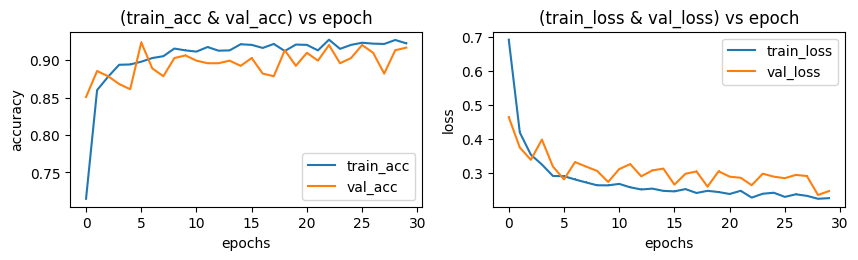

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()
#f.savefig('C:/Users/DHANVANTH/SAMSUNG/resnet_50_epoch_vs_acc', bbox_inches='tight', dpi=600)

In [ ]:
#model_1 = tensorflow.keras.models.load_model('RESNET_epoch_100.h5')

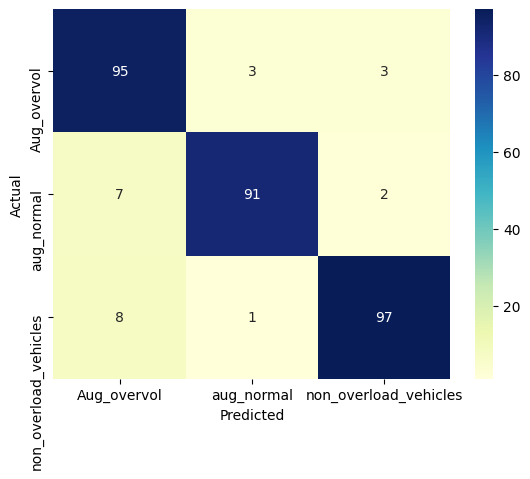

test accuracy: 92.18241042345277


In [ ]:
#to plot confusion matrix for 100 epochs
import pandas as pd
import seaborn as sn
import tensorflow as tf

#model = tf.keras.models.load_model("Reflection_dataset\Saved_Model\Mobilenet_reflection.h5")
#model = model_1
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap="YlGnBu", annot = True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
target = []
for x in train_generator.class_indices.keys():
  target.append(x)

target

['Aug_overvol', 'aug_normal', 'non_overload_vehicles']

ROC AUC score: 0.9415939389975262


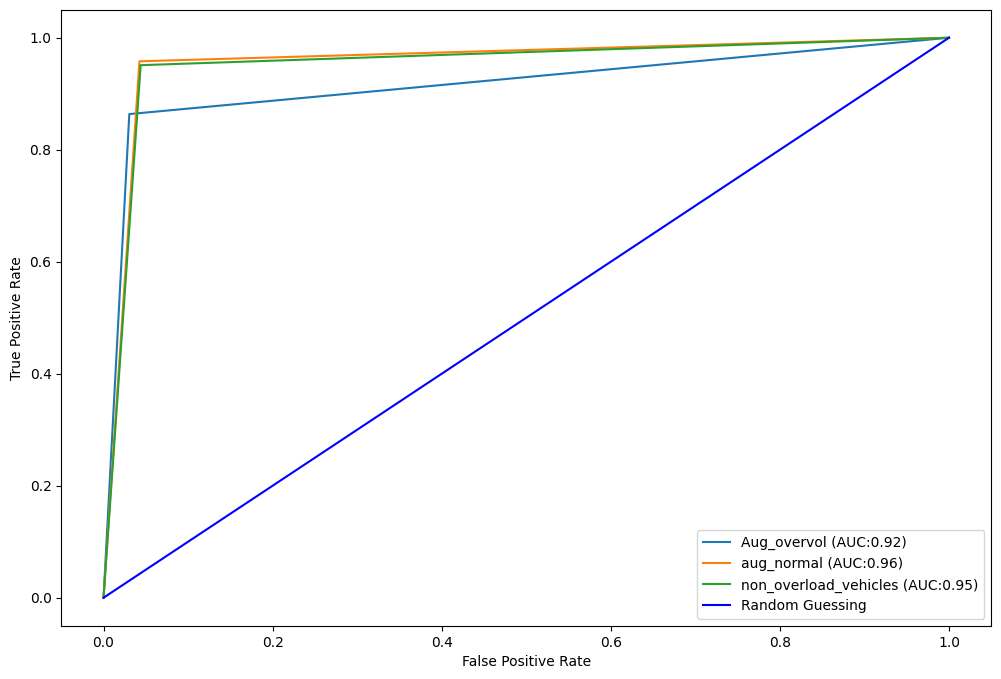

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


#target= ['airplane', 'automobile', 'bird', 'cat', 'deer',
   #       'dog', 'frog', 'horse', 'ship', 'truck']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, ypred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    ypred = lb.transform(ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(predicted_class, actual_class))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
#for image augmentation 

In [ ]:
import os
import cv2
import numpy as np
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

In [ ]:

#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [ ]:

transformations = {#'rotate anticlockwise': anticlockwise_rotation,
                  #    'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                  'blurring image':blur_image
                 }                #use dictionary to store names of functions 

images_path="C:/Users/DHANVANTH/SAMSUNG/z" #path to original images
augmented_path="C:/Users/DHANVANTH/SAMSUNG/y" # path to store aumented images
images=[] # to store paths of images from folder

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

images_to_generate=70
i=1                        # variable to iterate till images_to_generate

while i<=images_to_generate:    
    image=random.choice(images)
    original_image = io.imread(image)
    transformed_image=None
    print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
    while n <= transformation_count:
        key = random.choice(list(transformations)) #randomly choosing method to call
        transformed_image = transformations[key](original_image)
        n = n + 1
        
    new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i+2100)
    transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
    transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
    cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
    i =i+1
#to generate more images, put above 3 statement inside while n<... loop

In [ ]:
#to find the number of images in a file